# Case studies of Waroona and Sir Ivan fires


#### Most of these figures have their own scripts
just the images and descriptions are shown here.



#### fio is performed using iris
Iris has delayed file reading, and some interpolation/subsetting stuff that is quite good.


### Access model output (converted to netcdf)
 - Harvey Ye configures and runs ACCESS-Fire, which outputs GRIB and stash files 
 - Outputs are split into: 
   - single level [t, lat, lon] 
   - rho level [t, lev, lat, lon]
   - and theta level [t, lev, lat, lon]
 - 24 of each output file are produced, one for each hour, with 10 minute output timesteps
 - some model output variables are staggered in one dimension
 - I converted all these to netcdf using the Chun Su's iris conversion script


Horizontal winds are on staggered grids, but these are interpolated in my read_waroona_iris method. 
Some fields are on a staggered model level grid, WARNING: I have not interpolated this yet and plots may be half a level off.

### Fire model output (netcdf)
 - temporal resolution of 1 minute
 - each variable has 1 file per 24h (1440 length time dim)
 - fire_front is negative where fire has burnt, and positive where it has not burnt

fire fronts are shown by taking the 0 contour of the fire output 

In [1]:
###
###  Imports and globally useful stuff here
###
# Show plots in the browser
%matplotlib inline
#%matplotlib notebook

import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
#from matplotlib.colors import Normalize
import numpy as np
from datetime import datetime,timedelta

# Display an image from file:
from IPython.display import Image
#Image(filename='test.png') 

import iris
import iris.quickplot as qplt
from utilities import plotting, utils, fio

um_dtimes = [datetime(2016,1,5,15) + timedelta(hours=x) for x in np.arange(24,dtype=float)]

In [7]:
##
## READ WAROONA MODEL DATA INTO IRIS CUBES:
##
extent = plotting._extents_['waroona']
slv, ro1, th1, th2 = fio.read_waroona_iris(um_dtimes[0], extent=extent, add_winds=True, add_theta=True)

##
## READ FIREFRONT MODEL OUTPUT:
##
f_dtimes = [um_dtimes[-1] + timedelta(minutes=x) for x in np.arange(10,61,10,dtype=float)]
ff = fio.read_fire(dtimes=f_dtimes,extent=extent, firefront=True)

for cube in [slv,ro1,th1,th2]:
    print('============')
    print(cube)

print('============')
print(ff)

INFO: Reading(iris)  data/waroona/umnsaa_2016010515_slv.nc
INFO: Reading(iris)  data/waroona/umnsaa_2016010515_slv.nc
INFO: Reading(iris)  data/waroona/umnsaa_2016010515_mdl_ro1.nc
INFO: Reading(iris)  data/waroona/umnsaa_2016010515_mdl_th1.nc
INFO: Reading(iris)  data/waroona/umnsaa_2016010515_mdl_th2.nc
INFO: Reading(iris)  data/waroona_fire/firefront.CSIRO_24h.20160105T1500Z.nc
0: specific_humidity / (1)             (time: 6; latitude: 125; longitude: 152)
1: surface_air_pressure / (Pa)         (time: 6; latitude: 125; longitude: 152)
2: air_pressure_at_sea_level / (Pa)    (time: 6; latitude: 125; longitude: 152)
3: surface_temperature / (K)           (time: 6; latitude: 125; longitude: 152)
4: topog / (m)                         (latitude: 125; longitude: 152)
0: air_pressure / (Pa)                 (time: 6; model_level_number: 140; latitude: 125; longitude: 152)
1: x_wind / (m s-1)                    (time: 6; model_level_number: 140; latitude: 125; longitude: 152)
2: y_wind / (m 

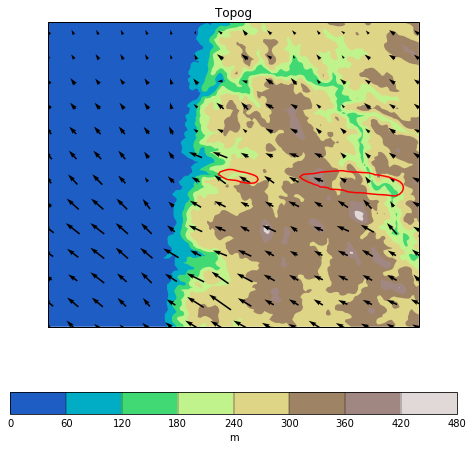

In [9]:
# check the topography
topog=slv.extract('topog')[0]
plt.figure(figsize=[8,8])
qplt.contourf(topog, cmap='terrain',vmin=-150) # set vmin so that blue range is around 0 or below

# show wind direction quiver plot
lat = topog.coord('latitude').points
lon = topog.coord('longitude').points
u,v = ro1[4][0,0].data, ro1[5][0,0].data
skip=slice(None,None,10)
plt.quiver(lon[skip],lat[skip],u[skip,skip],v[skip,skip], pivot='middle',scale=60)

# show fire front 
plt.contour(lon,lat,np.transpose(ff[0][0].data), np.array([0]),colors='r')
# this one only shows fire front after 2016010604ish when the fire starts

# show towns...


plt.show()

# First we examine model output

## Trying to determine what feedback can be seen in the model output
 1. Winds both horizontally and vertically can be examined through python visualisations
 2. cloud creation should be shown, due to the fire driven updrafts
   - Some updrafts are seen but they are relatively localised
 3. horizontal slices of vertical wind speed at different model levels may help pinpoint pyrogenic cloud formation

 
##### Often an examination is performed along a transect
 * Transects are formed using RectBivariateSpline interpolation along the line


## Transects

#### Where is the fire, where are we looking?
Several horizontal transects are used to examine vertical cross sections. These are shown here along with the fire front at the end of day 1.

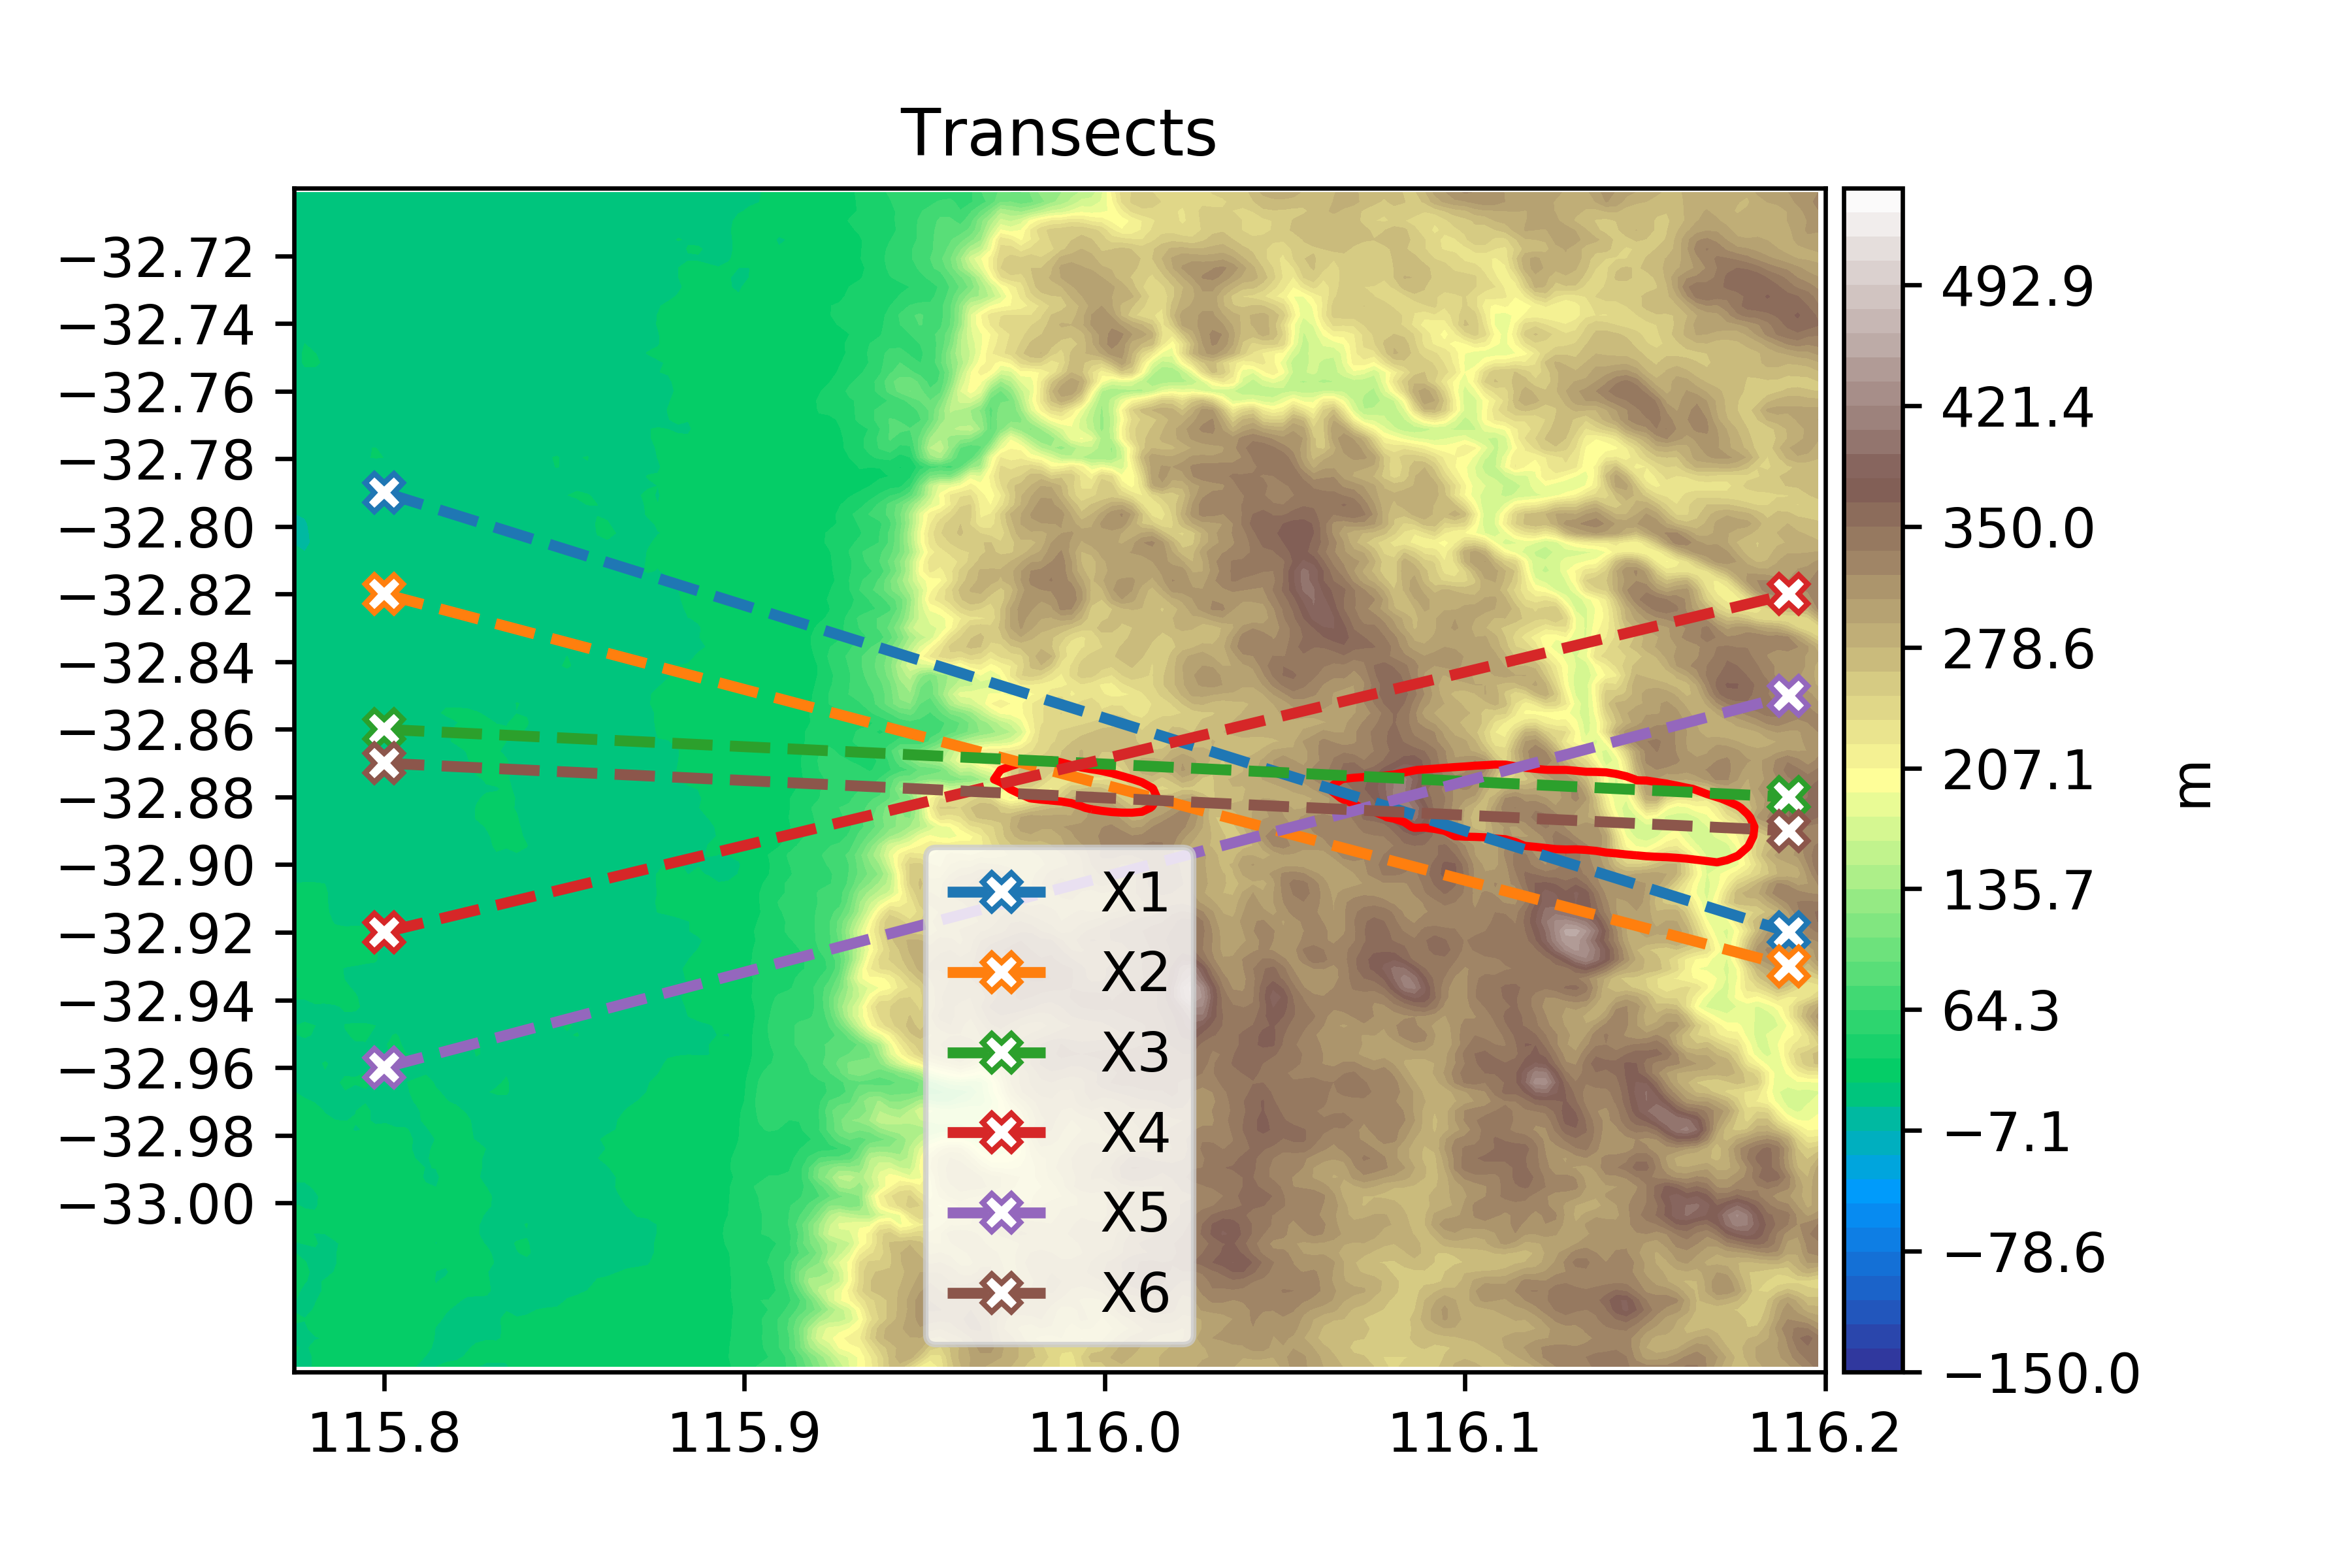

In [15]:
# Show transects

transects = plotting._transects_
extents = plotting._extents_

extentname='waroona'
plotting.map_topography(extents[extentname],topog.data,lat,lon)
plt.title("Transects")

plt.contour(lon,lat, np.transpose(ff[0][0].data),np.array([0]),colors='red')

for transect in range(6):
    start,end = transects["%s%d"%(extentname,transect+1)]
    plt.plot([start[1],end[1]],[start[0],end[0], ], '--', 
             linewidth=2, label='X%d'%(transect+1),
             marker='X', markersize=7,markerfacecolor='white')

plt.legend()
plt.yticks(np.arange(-33,-32.7,.02))
plt.xticks(np.arange(115.8,116.21,.1))
pname="figures/waroona/transects.png"
plt.savefig(pname,dpi=600)
plt.close()
Image(filename=pname)


## Modelled winds

Winds can be described using three vectors:
 1. x_winds: horizontal west-east wind speeds
 2. y_winds: horizontal south-north wind speeds
 3. upward : vertical wind speeds

These are summarised along each transect in the following plot.

### Outline of weather at fire site

#### 211 topography, sites of interest, surface wind, and transect line
First panel shows topography, wind speed, wind direction, and the current fire front

#### 223 vertical motion along transect
This panel shows vertical motion, and also outlines clouds using the 0.01g/kg threshold of cloud water + cloud ice

#### 224 horizontal wind speed along transect
Horzontal wind speed for each model level are calculated using the hypotenuse of x_winds and y_winds, and shown along the transect.

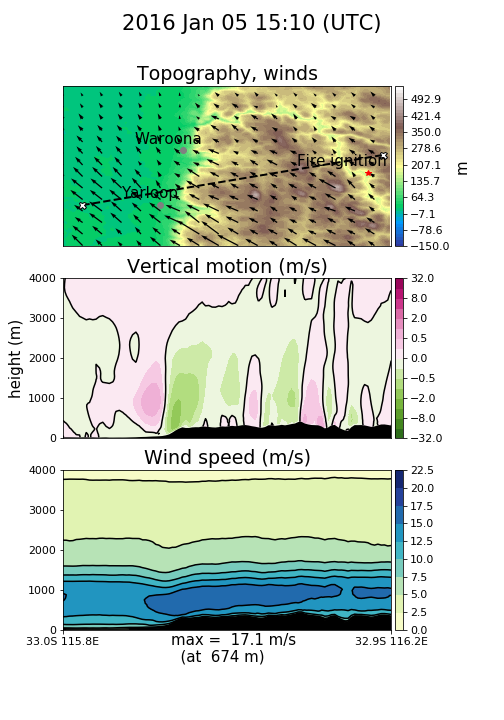

In [6]:
### The plot is written in wind_outline.py
## script can be run in NCI after running environment_setup.py

#from wind_outline import waroona_wind_loop
#waroona_wind_loop(um_dtimes[0])

# show example image:
Image(filename='figures/waroona/winds_outline_X5/fig_201601051510.png')

## Also looking for an idea of cloud formation driven by the fire

A similar plot to above is created showing vertical winds along with water and ice content.
Again the cloud threshold (0.01g/kg) is contoured.


In [ ]:
## EXAMPLE

# Figure created using cloud_outline.py
# from datetime import datetime
# from cloud_outline import waroona_cloud_loop
#
# waroona_cloud_loop(datetime(2016,1,6,8))

pname = 'figures/waroona/clouds_outline_X6/fig_201601060810.png'
Image(filename=pname)


## Turns out clouds are hard to pinpoint

#### Exploring horizontal slices at various model levels could help
 1. The vertical wind component can be roughly eyeballed by taking slices over various vertical levels
 2. cloud structure overplotted using water and ice content



In [74]:
Image(filename='figures/waroona/vert_motion_slices/fig_201601060810.png')

# Making videos from figures

#### ffmpeg video creation script is in the figures folder

accessfires$cat figures/make_video.sh
#!/bin/bash

#Run this from the subfolder with all your images in it
module load ffmpeg

ffmpeg -pattern_type glob -framerate 2 -i '*.png' -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p video.mp4
accessfires$